Here I simulated a stochastic SIR model using cayenne package. The simulation was adopted from this post:
https://medium.com/heuro-labs/cayenne-a-python-package-for-stochastic-simulations-3807dc4398f5

In [1]:
from cayenne import Simulation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dplython import (X, mutate) 
from plotnine import ggplot, aes, geom_line, facet_wrap, theme_bw


# Model
sir_stoch = """
    const compartment comp1;
    comp1 = 1.0;
    infection: S + I => I + I; k1;
    recovery: I => R; k2;
    k1 = 0.002;
    k2 = 0.1;
    chem_flag = false;
    I = 1;
    R = 0;
    S = 99;
"""

# Simulation
sim_time = 160 # time of simulation, 160 
nreps = 10 # number of replicates 

sim = Simulation.load_model(sir_stoch, "ModelString")
sim.simulate(max_t=sim_time, n_rep=nreps, max_iter=10_000, seed=0)
results = sim.results
sir_result = results.get_species(["S", "I","R"])
# sir_results[:1]  accessing the first round of iteration 

C:\Users\siari\anaconda3\lib\site-packages\cayenne\model_io.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In cayenne there is a nice way to plot the out put:

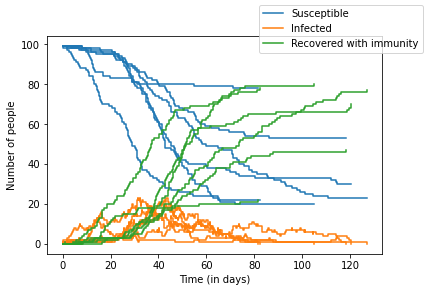

In [2]:
# Plotting
_, ax = sim.plot(new_names=["Susceptible", "Infected", "Recovered with immunity"])
ax.set_xlabel("Time (in days)")
ax.set_ylabel("Number of people")
plt.show()

The output of cayenne package come in a multi-dimentional array. I put all the simulation data in a panda dataframe:

In [3]:
time_vector = list(range(0,sim_time)) # a vector containing time points
rep_vector = range(1,nreps+1) # a vector that stores the number of replicates

# putting the results in a data frame
data_sir = {                         
  "time": time_vector*nreps, # time vector multiplied by the number of rep
  "rep": np.repeat(rep_vector, sim_time), # rep vector each element repeated by the time length 
  "S": np.repeat(np.nan, sim_time*nreps), # assigning na vlaues to the number of all output time_length* #_reps
  "I": np.repeat(np.nan, sim_time*nreps),
  "R": np.repeat(np.nan, sim_time*nreps)
}

# creating a dataframe for SIR data 
df_sir = pd.DataFrame(data_sir) 

for i in rep_vector:
    for j in time_vector:
        try:
            # sirtime is a row from sir_result in rep i-1 (cuz is a vector) and time j
            sirtime = sir_result[i-1][j]
        except:
            pass
        else:
            # Assigning values at rep i & time j
            df_sir.at[(df_sir['rep']==i)&(df_sir['time']==j),['S','I','R']] = sirtime
            
df_sir

,time,rep,S,I,R
0,0,1,99.0,1.0,0.0
1,1,1,98.0,2.0,0.0
2,2,1,97.0,3.0,0.0
3,3,1,96.0,4.0,0.0
4,4,1,96.0,3.0,1.0
...,...,...,...,...,...
1595,155,10,NaN,NaN,NaN
1596,156,10,NaN,NaN,NaN
1597,157,10,NaN,NaN,NaN
1598,158,10,NaN,NaN,NaN


Now we have all the info in a nice table, for plotting in ggplot we can melt the dataframe and convert it to a long format:

In [4]:
# melting df_sir to have a long data set for ggplot
df_sir_long = pd.melt(df_sir, id_vars=['time','rep'], value_vars=['S','I','R'],
                      var_name='type', value_name='population')

df_sir_long

,time,rep,type,population
0,0,1,S,99.0
1,1,1,S,98.0
2,2,1,S,97.0
3,3,1,S,96.0
4,4,1,S,96.0
...,...,...,...,...
4795,155,10,R,NaN
4796,156,10,R,NaN
4797,157,10,R,NaN
4798,158,10,R,NaN


Now, I can use ggplot:

C:\Users\siari\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 158 rows containing missing values.
C:\Users\siari\anaconda3\lib\site-packages\plotnine\guides\guide_legend.py:308: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


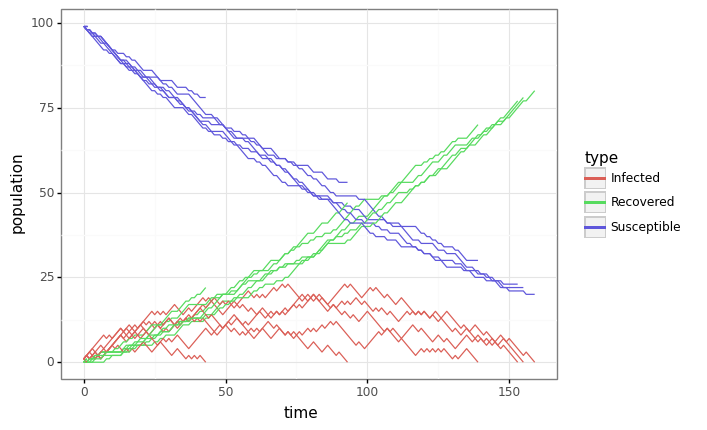

In [5]:
# I haven't found a good way to do group=interaction(var1,var2) 
# here I combine two columns to have an interaction of rep~type then I plot them
df2 = df_sir_long
# .apply(str) cast the rep as an int to str
df2['rep'] = df2['rep'].apply(str)
# mutate makes a new column based on rep & type
df2 = df2 >> mutate(comb=X.rep+X.type)

df2["type"].replace({'S':"Susceptible",'I':"Infected",'R':"Recovered"},inplace=True)
print(ggplot(df2)+aes(x='time',y='population',group='comb',colour='type')
      + geom_line() + theme_bw())